# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        fold=1,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../logs/comick/79_contexts/10-11-2022_19-39-04/oov_embedding_dict.pkl", "rb"))
oov_embeddings = {key: np.zeros((64), dtype=np.float32) for key, _ in oov_embeddings.items()}

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/zero/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/zero/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/zero/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../logs/zero/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5119 | MulticlassF1Score=0.0705
Batch-30 : CrossEntropyLoss=2.4722 | MulticlassF1Score=0.1555
Batch-45 : CrossEntropyLoss=2.4668 | MulticlassF1Score=0.1831
Batch-60 : CrossEntropyLoss=2.4770 | MulticlassF1Score=0.2040
Batch-75 : CrossEntropyLoss=2.4531 | MulticlassF1Score=0.2379
Batch-90 : CrossEntropyLoss=2.4042 | MulticlassF1Score=0.2876
Batch-105: CrossEntropyLoss=2.3764 | MulticlassF1Score=0.3251
Batch-120: CrossEntropyLoss=2.3818 | MulticlassF1Score=0.3540
Batch-135: CrossEntropyLoss=2.3737 | MulticlassF1Score=0.3782
Batch-150: CrossEntropyLoss=2.3354 | MulticlassF1Score=0.4023
Batch-165: CrossEntropyLoss=2.3466 | MulticlassF1Score=0.4269
Batch-180: CrossEntropyLoss=2.3458 | MulticlassF1Score=0.4480
Batch-195: CrossEntropyLoss=2.3451 | MulticlassF1Score=0.4670
Batch-210: CrossEntropyLoss=2.3299 | MulticlassF1Score=0.4824
Batch-225: CrossEntropyLoss=2.3314 | MulticlassF1Score=0.4967
Batch-226: CrossEntropyLoss=2.3380 | MulticlassF1Score=0.4973

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3471 | MulticlassF1Score=0.6899
Batch-30 : CrossEntropyLoss=2.3514 | MulticlassF1Score=0.6881
Batch-45 : CrossEntropyLoss=2.3404 | MulticlassF1Score=0.6916
Batch-60 : CrossEntropyLoss=2.3411 | MulticlassF1Score=0.6909
Batch-63 : CrossEntropyLoss=2.3314 | MulticlassF1Score=0.6900

Training   : Mean CrossEntropyLoss = 2.4143 | Mean MulticlassF1Score = 0.3148
Validation : Mean CrossEntropyLoss = 2.3453 | Mean MulticlassF1Score = 0.6905

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3353 | MulticlassF1Score=0.7002
Batch-30 : CrossEntropyLoss=2.3333 | MulticlassF1Score=0.7040
Batch-45 : CrossEntropyLoss=2.3425 | MulticlassF1Score=0.7158
Batch-60 : CrossEntropyLoss=2.3274 | MulticlassF1Score=0.7192
Batch-75 : CrossEntropyLoss=2.3278 | MulticlassF1Score=0.7279
Batch-90 : CrossEntropyLoss=2.3259 | MulticlassF1Score=0.7332
Batch-105: CrossEntropyLoss=2.3309 | MulticlassF1Score=0.7379
Batch-120: CrossEntropyLoss=2.3287 | MulticlassF1Score=0.7418
Batch-135: CrossEntropyLoss=2.3299 | MulticlassF1Score=0.7443
Batch-150: CrossEntropyLoss=2.3242 | MulticlassF1Score=0.7465
Batch-165: CrossEntropyLoss=2.3178 | MulticlassF1Score=0.7472
Batch-180: CrossEntropyLoss=2.3171 | MulticlassF1Score=0.7491
Batch-195: CrossEntropyLoss=2.3220 | MulticlassF1Score=0.7507
Batch-210: CrossEntropyLoss=2.3321 | MulticlassF1Score=0.7519
Batch-225: CrossEntropyLoss=2.3137 | MulticlassF1Score=0.7532
Batch-226: CrossEntropyLoss=2.3140 | MulticlassF1Score=0.7533

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3149 | MulticlassF1Score=0.7691
Batch-30 : CrossEntropyLoss=2.3095 | MulticlassF1Score=0.7692
Batch-45 : CrossEntropyLoss=2.3140 | MulticlassF1Score=0.7684
Batch-60 : CrossEntropyLoss=2.3081 | MulticlassF1Score=0.7693
Batch-63 : CrossEntropyLoss=2.3145 | MulticlassF1Score=0.7701

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3249 | Mean MulticlassF1Score = 0.7332
Validation : Mean CrossEntropyLoss = 2.3199 | Mean MulticlassF1Score = 0.7703

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3201 | MulticlassF1Score=0.7758
Batch-30 : CrossEntropyLoss=2.3144 | MulticlassF1Score=0.7747
Batch-45 : CrossEntropyLoss=2.3245 | MulticlassF1Score=0.7718
Batch-60 : CrossEntropyLoss=2.3157 | MulticlassF1Score=0.7719
Batch-75 : CrossEntropyLoss=2.3246 | MulticlassF1Score=0.7714
Batch-90 : CrossEntropyLoss=2.3190 | MulticlassF1Score=0.7725
Batch-105: CrossEntropyLoss=2.3268 | MulticlassF1Score=0.7733
Batch-120: CrossEntropyLoss=2.3091 | MulticlassF1Score=0.7754
Batch-135: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.7769
Batch-150: CrossEntropyLoss=2.3110 | MulticlassF1Score=0.7790
Batch-165: CrossEntropyLoss=2.3261 | MulticlassF1Score=0.7793
Batch-180: CrossEntropyLoss=2.3167 | MulticlassF1Score=0.7808
Batch-195: CrossEntropyLoss=2.3101 | MulticlassF1Score=0.7829
Batch-210: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.7848
Batch-225: CrossEntropyLoss=2.3158 | MulticlassF1Score=0.7867
Batch-226: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.7868

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3184 | MulticlassF1Score=0.8103
Batch-30 : CrossEntropyLoss=2.3150 | MulticlassF1Score=0.8126
Batch-45 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8097
Batch-60 : CrossEntropyLoss=2.3220 | MulticlassF1Score=0.8084
Batch-63 : CrossEntropyLoss=2.3108 | MulticlassF1Score=0.8083

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3141 | Mean MulticlassF1Score = 0.7765
Validation : Mean CrossEntropyLoss = 2.3079 | Mean MulticlassF1Score = 0.8109

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3072 | MulticlassF1Score=0.8138
Batch-30 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8120
Batch-45 : CrossEntropyLoss=2.3113 | MulticlassF1Score=0.8120
Batch-60 : CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8129
Batch-75 : CrossEntropyLoss=2.3081 | MulticlassF1Score=0.8132
Batch-90 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8155
Batch-105: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8170
Batch-120: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8177
Batch-135: CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8174
Batch-150: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8182
Batch-165: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8179
Batch-180: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8185
Batch-195: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8194
Batch-210: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8202
Batch-225: CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8201
Batch-226: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8201

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3144 | MulticlassF1Score=0.8199
Batch-30 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8218
Batch-45 : CrossEntropyLoss=2.3081 | MulticlassF1Score=0.8219
Batch-60 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8219
Batch-63 : CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8217

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3038 | Mean MulticlassF1Score = 0.8165
Validation : Mean CrossEntropyLoss = 2.3035 | Mean MulticlassF1Score = 0.8218

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8259
Batch-30 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8247
Batch-45 : CrossEntropyLoss=2.3097 | MulticlassF1Score=0.8269
Batch-60 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8266
Batch-75 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8267
Batch-90 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8267
Batch-105: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8273
Batch-120: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8267
Batch-135: CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8265
Batch-150: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8264
Batch-165: CrossEntropyLoss=2.3114 | MulticlassF1Score=0.8262
Batch-180: CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8260
Batch-195: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8257
Batch-210: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8254
Batch-225: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8253
Batch-226: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8253

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3160 | MulticlassF1Score=0.8162
Batch-30 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8187
Batch-45 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8224
Batch-60 : CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8241
Batch-63 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8241

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3020 | Mean MulticlassF1Score = 0.8258
Validation : Mean CrossEntropyLoss = 2.3025 | Mean MulticlassF1Score = 0.8206

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8211
Batch-30 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8251
Batch-45 : CrossEntropyLoss=2.3076 | MulticlassF1Score=0.8270
Batch-60 : CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8280
Batch-75 : CrossEntropyLoss=2.3124 | MulticlassF1Score=0.8288
Batch-90 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8286
Batch-105: CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8290
Batch-120: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8288
Batch-135: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8284
Batch-150: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8278
Batch-165: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8281
Batch-180: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8280
Batch-195: CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8284
Batch-210: CrossEntropyLoss=2.3112 | MulticlassF1Score=0.8281
Batch-225: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8282
Batch-226: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8283

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8292
Batch-30 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8277
Batch-45 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8263
Batch-60 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8257
Batch-63 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8262

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3009 | Mean MulticlassF1Score = 0.8274
Validation : Mean CrossEntropyLoss = 2.3018 | Mean MulticlassF1Score = 0.8266

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8277
Batch-30 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8279
Batch-45 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8299
Batch-60 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8298
Batch-75 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8310
Batch-90 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8307
Batch-105: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8316
Batch-120: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8342
Batch-135: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8366
Batch-150: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8385
Batch-165: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8396
Batch-180: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8402
Batch-195: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8413
Batch-210: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8426
Batch-225: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8434
Batch-226: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8435

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8502
Batch-30 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8519
Batch-45 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8496
Batch-60 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8513
Batch-63 : CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8507

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2963 | Mean MulticlassF1Score = 0.8345
Validation : Mean CrossEntropyLoss = 2.2946 | Mean MulticlassF1Score = 0.8499

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8669
Batch-30 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8615
Batch-45 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8608
Batch-60 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8595
Batch-75 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8591
Batch-90 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8592
Batch-105: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8608
Batch-120: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8618
Batch-135: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8629
Batch-150: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8640
Batch-165: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8652
Batch-180: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8662
Batch-195: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8664
Batch-210: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8672
Batch-225: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8681
Batch-226: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8681

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8742
Batch-30 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8732
Batch-45 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8736
Batch-60 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8736
Batch-63 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8738

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2889 | Mean MulticlassF1Score = 0.8629
Validation : Mean CrossEntropyLoss = 2.2874 | Mean MulticlassF1Score = 0.8739

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8763
Batch-30 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8779
Batch-45 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8797
Batch-60 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8804
Batch-75 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8809
Batch-90 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8823
Batch-105: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8846
Batch-120: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8872
Batch-135: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.8886
Batch-150: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8902
Batch-165: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8919
Batch-180: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8932
Batch-195: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8943
Batch-210: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8952
Batch-225: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8958
Batch-226: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8958

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9016
Batch-30 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9051
Batch-45 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9032
Batch-60 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9026
Batch-63 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9029

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2804 | Mean MulticlassF1Score = 0.8863
Validation : Mean CrossEntropyLoss = 2.2784 | Mean MulticlassF1Score = 0.9034

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9078
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9112
Batch-45 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9120
Batch-60 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9107
Batch-75 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9102
Batch-90 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9110
Batch-105: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9112
Batch-120: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9106
Batch-135: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9107
Batch-150: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9109
Batch-165: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9107
Batch-180: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9109
Batch-195: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9107
Batch-210: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9105
Batch-225: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9106
Batch-226: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9106

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9046
Batch-30 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9030
Batch-45 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.9034
Batch-60 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9046
Batch-63 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9045

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2757 | Mean MulticlassF1Score = 0.9105
Validation : Mean CrossEntropyLoss = 2.2777 | Mean MulticlassF1Score = 0.9031

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9096
Batch-30 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9099
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9114
Batch-60 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9126
Batch-75 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9126
Batch-90 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9124
Batch-105: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9131
Batch-120: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9132
Batch-135: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9136
Batch-150: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9137
Batch-165: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9139
Batch-180: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9136
Batch-195: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9139
Batch-210: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9139
Batch-225: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9140
Batch-226: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9140

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9048
Batch-30 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9031
Batch-45 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9039
Batch-60 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9048
Batch-63 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9057

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9122
Validation : Mean CrossEntropyLoss = 2.2772 | Mean MulticlassF1Score = 0.9044

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9202
Batch-30 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9156
Batch-45 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9177
Batch-60 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9166
Batch-75 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9165
Batch-90 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9162
Batch-105: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9161
Batch-120: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9160
Batch-135: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9160
Batch-150: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9161
Batch-165: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9161
Batch-180: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9162
Batch-195: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9163
Batch-210: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9162
Batch-225: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9164
Batch-226: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9163

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9048
Batch-30 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9045
Batch-45 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9059
Batch-60 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9070
Batch-63 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9071

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2737 | Mean MulticlassF1Score = 0.9167
Validation : Mean CrossEntropyLoss = 2.2766 | Mean MulticlassF1Score = 0.9046

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9245
Batch-45 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9220
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9222
Batch-75 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9216
Batch-90 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9213
Batch-105: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.9207
Batch-120: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9201
Batch-135: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9197
Batch-150: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9196
Batch-165: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9195
Batch-180: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9196
Batch-195: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9193
Batch-210: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9190
Batch-225: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9186
Batch-226: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9186

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9021
Batch-30 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9048
Batch-45 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.9061
Batch-60 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9076
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9076

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2730 | Mean MulticlassF1Score = 0.9215
Validation : Mean CrossEntropyLoss = 2.2765 | Mean MulticlassF1Score = 0.9063

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9179
Batch-30 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9203
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9228
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9228
Batch-75 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9223
Batch-90 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9220
Batch-105: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9220
Batch-120: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9225
Batch-135: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9228
Batch-150: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9226
Batch-165: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9228
Batch-180: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9229
Batch-195: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9227
Batch-210: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9229
Batch-225: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.9231
Batch-226: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9231

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9114
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9138
Batch-45 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.9134
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9125
Batch-63 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.9121

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9221
Validation : Mean CrossEntropyLoss = 2.2751 | Mean MulticlassF1Score = 0.9136

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9263
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9281
Batch-45 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9270
Batch-60 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9267
Batch-75 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9272
Batch-90 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9260
Batch-105: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9260
Batch-120: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9261
Batch-135: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9261
Batch-150: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9264
Batch-165: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9265
Batch-180: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9260
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9258
Batch-210: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9260
Batch-225: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9258
Batch-226: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9258

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9154
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9137
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9132
Batch-60 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9120
Batch-63 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9122

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9265
Validation : Mean CrossEntropyLoss = 2.2750 | Mean MulticlassF1Score = 0.9143

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9255
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9284
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9290
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9288
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9285
Batch-90 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9283
Batch-105: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9290
Batch-120: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9286
Batch-135: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9287
Batch-150: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9287
Batch-165: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9287
Batch-180: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9286
Batch-195: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9286
Batch-210: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9283
Batch-225: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9279
Batch-226: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9279

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9091
Batch-30 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9116
Batch-45 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.9117
Batch-60 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9136
Batch-63 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.9134

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9284
Validation : Mean CrossEntropyLoss = 2.2748 | Mean MulticlassF1Score = 0.9108

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9273
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9279
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9272
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9283
Batch-75 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9278
Batch-90 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9280
Batch-105: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9276
Batch-120: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9277
Batch-135: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9277
Batch-150: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9276
Batch-165: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9277
Batch-180: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9276
Batch-195: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9275
Batch-210: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9273
Batch-225: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9274
Batch-226: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9274

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9092
Batch-30 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9137
Batch-45 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9144
Batch-60 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9132
Batch-63 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9131

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9276
Validation : Mean CrossEntropyLoss = 2.2748 | Mean MulticlassF1Score = 0.9131
Patience = 1/50❗

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9325
Batch-30 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9311
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9300
Batch-60 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9291
Batch-75 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9291
Batch-90 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9295
Batch-105: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9297
Batch-120: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9296
Batch-135: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9290
Batch-150: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9289
Batch-165: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9286
Batch-180: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9283
Batch-195: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9283
Batch-210: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9284
Batch-225: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9290
Batch-226: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9290

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9119
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9124
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9136
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9129
Batch-63 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9134

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9293
Validation : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9130

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9308
Batch-30 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9309
Batch-45 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9303
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9306
Batch-75 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9312
Batch-90 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9309
Batch-105: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9311
Batch-120: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9310
Batch-135: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9310
Batch-150: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9312
Batch-165: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9317
Batch-180: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9320
Batch-195: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9320
Batch-210: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9320
Batch-225: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9322
Batch-226: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9323

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9171
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9168
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9176
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9162
Batch-63 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.9160

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2685 | Mean MulticlassF1Score = 0.9310
Validation : Mean CrossEntropyLoss = 2.2739 | Mean MulticlassF1Score = 0.9167

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9370
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9356
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9344
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9336
Batch-75 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9338
Batch-90 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9332
Batch-105: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9334
Batch-120: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9334
Batch-135: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9332
Batch-150: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9334
Batch-165: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9334
Batch-180: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9333
Batch-195: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9334
Batch-210: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9334
Batch-225: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9332
Batch-226: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9332

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9162
Batch-30 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9146
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9158
Batch-60 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9144
Batch-63 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9147

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2682 | Mean MulticlassF1Score = 0.9337
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9167

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9320
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9313
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9316
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9315
Batch-75 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9326
Batch-90 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9328
Batch-105: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9326
Batch-120: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9324
Batch-135: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9325
Batch-150: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9327
Batch-165: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9326
Batch-180: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9330
Batch-195: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9331
Batch-210: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9336
Batch-225: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9339
Batch-226: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9339

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9159
Batch-30 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9146
Batch-45 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9156
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9170
Batch-63 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9168

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2680 | Mean MulticlassF1Score = 0.9324
Validation : Mean CrossEntropyLoss = 2.2736 | Mean MulticlassF1Score = 0.9159

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9316
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9352
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9356
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9357
Batch-75 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9358
Batch-90 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9362
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9358
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9361
Batch-135: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9363
Batch-150: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9364
Batch-165: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9363
Batch-180: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9361
Batch-195: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9362
Batch-210: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9360
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9358
Batch-226: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9359

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9194
Batch-30 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9191
Batch-45 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9175
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9172
Batch-63 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9169

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9356
Validation : Mean CrossEntropyLoss = 2.2735 | Mean MulticlassF1Score = 0.9196

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9345
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9353
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9352
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9349
Batch-75 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9353
Batch-90 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9353
Batch-105: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9356
Batch-120: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9359
Batch-135: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9361
Batch-150: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9363
Batch-165: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9364
Batch-180: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9366
Batch-195: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9366
Batch-210: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9364
Batch-225: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9365
Batch-226: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9365

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9204
Batch-30 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9176
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9189
Batch-60 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9167
Batch-63 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9171

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9359
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9186

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9399
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9369
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9373
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9371
Batch-75 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9381
Batch-90 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9373
Batch-105: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9367
Batch-120: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9364
Batch-135: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9366
Batch-150: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9366
Batch-165: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9367
Batch-180: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9368
Batch-195: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9372
Batch-210: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9372
Batch-225: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9370
Batch-226: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9371

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9152
Batch-30 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9157
Batch-45 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9186
Batch-60 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9178
Batch-63 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9172

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9373
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9168

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9413
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9403
Batch-45 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9396
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9393
Batch-75 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9393
Batch-90 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9393
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9391
Batch-120: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9387
Batch-135: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9387
Batch-150: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9390
Batch-165: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9390
Batch-180: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9388
Batch-195: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9382
Batch-210: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9380
Batch-225: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9379
Batch-226: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9379

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9199
Batch-30 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9191
Batch-45 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9186
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9177
Batch-63 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9176

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9390
Validation : Mean CrossEntropyLoss = 2.2732 | Mean MulticlassF1Score = 0.9190

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9424
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9420
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9409
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9404
Batch-75 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9398
Batch-90 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9390
Batch-105: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9385
Batch-120: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9387
Batch-135: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9389
Batch-150: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9388
Batch-165: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9386
Batch-180: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9388
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9386
Batch-210: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9394
Batch-225: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9404
Batch-226: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9404

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9341
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9361
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9370
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9364
Batch-63 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9367

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9398
Validation : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9348

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9560
Batch-30 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9556
Batch-45 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9564
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9572
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9580
Batch-90 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9578
Batch-105: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9580
Batch-120: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9575
Batch-135: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9570
Batch-150: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9571
Batch-165: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9570
Batch-180: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9568
Batch-195: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9569
Batch-210: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9567
Batch-225: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9569
Batch-226: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9569

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9398
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9380
Batch-45 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9373
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9372
Batch-63 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9371

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2610 | Mean MulticlassF1Score = 0.9571
Validation : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9374

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9591
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9584
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9583
Batch-60 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9583
Batch-75 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9585
Batch-90 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9582
Batch-105: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9584
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9579
Batch-135: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9579
Batch-150: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9577
Batch-165: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9577
Batch-180: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9580
Batch-195: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9578
Batch-210: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9576
Batch-225: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9575
Batch-226: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9575

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9351
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9371
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9370
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9366
Batch-63 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9370

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2607 | Mean MulticlassF1Score = 0.9576
Validation : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9373

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9579
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9574
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9586
Batch-60 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9588
Batch-75 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9585
Batch-90 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9584
Batch-105: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9585
Batch-120: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9582
Batch-135: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9581
Batch-150: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9582
Batch-165: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9583
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9582
Batch-195: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9582
Batch-210: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9581
Batch-225: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9578
Batch-226: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9578

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9335
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9345
Batch-45 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9369
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9368
Batch-63 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9366

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2606 | Mean MulticlassF1Score = 0.9582
Validation : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9347

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9584
Batch-30 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9566
Batch-45 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9577
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9581
Batch-75 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9584
Batch-90 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9589
Batch-105: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9590
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9589
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9587
Batch-150: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9588
Batch-165: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9586
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9589
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9586
Batch-210: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9587
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9584
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9584

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9348
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9345
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9350
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9361
Batch-63 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9365

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2603 | Mean MulticlassF1Score = 0.9584
Validation : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9357

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9605
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9605
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9604
Batch-60 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9601
Batch-75 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9603
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9605
Batch-105: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9603
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9600
Batch-135: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9597
Batch-150: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9598
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9598
Batch-180: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9598
Batch-195: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9599
Batch-210: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9595
Batch-225: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9594
Batch-226: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9594

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9359
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9374
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9365
Batch-60 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9373
Batch-63 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9373

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2600 | Mean MulticlassF1Score = 0.9600
Validation : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9369

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9623
Batch-30 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9610
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9609
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9609
Batch-75 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9610
Batch-90 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9609
Batch-105: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9603
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9601
Batch-135: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9601
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9601
Batch-165: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9601
Batch-180: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9599
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9598
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9596
Batch-225: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9597
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9597

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9377
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9366
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9375
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9380
Batch-63 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9375

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2599 | Mean MulticlassF1Score = 0.9603
Validation : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9370

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9612
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9614
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9607
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9601
Batch-75 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9599
Batch-90 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9593
Batch-105: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9598
Batch-120: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9596
Batch-135: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9599
Batch-150: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9596
Batch-165: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9596
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9597
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9599
Batch-210: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9598
Batch-225: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9599
Batch-226: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9598

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9346
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9360
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9370
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9373
Batch-63 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9374

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2599 | Mean MulticlassF1Score = 0.9601
Validation : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9364

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9607
Batch-30 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9606
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9595
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9600
Batch-75 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9606
Batch-90 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9601
Batch-105: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9598
Batch-120: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9601
Batch-135: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9599
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9594
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9596
Batch-180: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9596
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9595
Batch-210: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9594
Batch-225: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9594
Batch-226: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9594

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9408
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9389
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9378
Batch-60 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9378
Batch-63 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9375

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2600 | Mean MulticlassF1Score = 0.9597
Validation : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9390
Patience = 2/50❗

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9595
Batch-30 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9597
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9600
Batch-60 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9597
Batch-75 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9601
Batch-90 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9599
Batch-105: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9603
Batch-120: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9599
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9600
Batch-150: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9599
Batch-165: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9596
Batch-180: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9598
Batch-195: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9598
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9599
Batch-225: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9599
Batch-226: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9599

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9363
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9367
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9373
Batch-60 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9369
Batch-63 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9371

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2599 | Mean MulticlassF1Score = 0.9597
Validation : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9376

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9581
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9588
Batch-45 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9594
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9594
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9598
Batch-90 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9600
Batch-105: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9599
Batch-120: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9600
Batch-135: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9599
Batch-150: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9597
Batch-165: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9599
Batch-180: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9601
Batch-195: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9601
Batch-210: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9602
Batch-225: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9605
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9605

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9381
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9376
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9379
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9385
Batch-63 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9383

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2597 | Mean MulticlassF1Score = 0.9597
Validation : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9364

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9599
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9603
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9611
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9605
Batch-75 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9604
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9607
Batch-105: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9606
Batch-120: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9608
Batch-135: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9608
Batch-150: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9608
Batch-165: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9609
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9609
Batch-195: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9610
Batch-210: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9608
Batch-225: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9608
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9607

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9359
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9355
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9370
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9375
Batch-63 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9377

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2596 | Mean MulticlassF1Score = 0.9606
Validation : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9371

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9625
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9636
Batch-45 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9626
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9627
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9629
Batch-90 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9622
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9617
Batch-120: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9616
Batch-135: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9616
Batch-150: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9618
Batch-165: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9615
Batch-180: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9612
Batch-195: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9611
Batch-210: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9613
Batch-225: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9609
Batch-226: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9609

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9345
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9343
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9354
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9360
Batch-63 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9364

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2595 | Mean MulticlassF1Score = 0.9620
Validation : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9347

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9618
Batch-30 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9616
Batch-45 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9604
Batch-60 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9607
Batch-75 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9613
Batch-90 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9614
Batch-105: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9611
Batch-120: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9610
Batch-135: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9610
Batch-150: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9611
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9612
Batch-180: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9608
Batch-195: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9612
Batch-210: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9612
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9612
Batch-226: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9612

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9352
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9372
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9377
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9371
Batch-63 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9372

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2594 | Mean MulticlassF1Score = 0.9613
Validation : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9367

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9635
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9640
Batch-45 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9630
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9628
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9626
Batch-90 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9626
Batch-105: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9620
Batch-120: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9616
Batch-135: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9616
Batch-150: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9618
Batch-165: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9618
Batch-180: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9616
Batch-195: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9614
Batch-210: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9612
Batch-225: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9613
Batch-226: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9613

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9344
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9368
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9378
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9376
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9377

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2594 | Mean MulticlassF1Score = 0.9622
Validation : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9361

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9644
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9621
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9611
Batch-60 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9615
Batch-75 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9622
Batch-90 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9625
Batch-105: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9619
Batch-120: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9620
Batch-135: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9617
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9617
Batch-165: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9617
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9618
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9618
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9620
Batch-225: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9618
Batch-226: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9618

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9370
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9380
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9382
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9372
Batch-63 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9370

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2592 | Mean MulticlassF1Score = 0.9621
Validation : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9370

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9612
Batch-30 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9623
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9621
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9615
Batch-75 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9615
Batch-90 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9619
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9616
Batch-120: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9621
Batch-135: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9621
Batch-150: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9619
Batch-165: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9618
Batch-180: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9618
Batch-195: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9620
Batch-210: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9619
Batch-225: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9618
Batch-226: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9618

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9395
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9388
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9375
Batch-60 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9377
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9377

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2592 | Mean MulticlassF1Score = 0.9618
Validation : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9379
Patience = 3/50❗

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9615
Batch-30 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9617
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9620
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9617
Batch-75 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9605
Batch-90 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9608
Batch-105: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9605
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9602
Batch-135: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9605
Batch-150: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9608
Batch-165: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9608
Batch-180: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9612
Batch-195: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9612
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9614
Batch-225: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9615
Batch-226: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9616

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9425
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9385
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9385
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9377
Batch-63 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9375

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2593 | Mean MulticlassF1Score = 0.9612
Validation : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9390
Patience = 4/50❗

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9606
Batch-30 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9623
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9621
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9615
Batch-75 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9624
Batch-90 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9623
Batch-105: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9626
Batch-120: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9624
Batch-135: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9624
Batch-150: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9621
Batch-165: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9622
Batch-180: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9621
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9619
Batch-210: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9623
Batch-225: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9622
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9622

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9387
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9375
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9391
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9383
Batch-63 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9379

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9622
Validation : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9378

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9630
Batch-30 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9644
Batch-45 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9631
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9625
Batch-75 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9618
Batch-90 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9617
Batch-105: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9623
Batch-120: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9620
Batch-135: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9617
Batch-150: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9620
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9621
Batch-180: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9621
Batch-195: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9621
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9619
Batch-225: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9622
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9622

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9406
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9381
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9376
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9373
Batch-63 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9371

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9626
Validation : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9380
Patience = 5/50❗

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9622
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9615
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9615
Batch-60 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9617
Batch-75 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9624
Batch-90 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9621
Batch-105: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9620
Batch-120: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9623
Batch-135: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9622
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9621
Batch-165: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9621
Batch-180: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9622
Batch-195: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9623
Batch-210: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9620
Batch-225: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9619
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9619

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9404
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9389
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9391
Batch-60 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9370
Batch-63 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9370

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2592 | Mean MulticlassF1Score = 0.9619
Validation : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9393
Patience = 6/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9595
Batch-30 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9607
Batch-45 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9607
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9620
Batch-75 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9620
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9622
Batch-105: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9623
Batch-120: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9620
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9621
Batch-150: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9621
Batch-165: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9617
Batch-180: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9617
Batch-195: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9619
Batch-210: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9620
Batch-225: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9620
Batch-226: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9619

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9389
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9374
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9374
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9375
Batch-63 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9376

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2592 | Mean MulticlassF1Score = 0.9618
Validation : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9387

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9620
Batch-30 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9622
Batch-45 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9617
Batch-60 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9618
Batch-75 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9614
Batch-90 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9616
Batch-105: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9617
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9618
Batch-135: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9619
Batch-150: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9620
Batch-165: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9622
Batch-180: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9621
Batch-195: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9622
Batch-210: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9622
Batch-225: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9622
Batch-226: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9622

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9346
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9376
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9377
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9377
Batch-63 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9377

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9620
Validation : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9366

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9654
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9665
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9640
Batch-60 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9626
Batch-75 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9622
Batch-90 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9619
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9626
Batch-120: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9628
Batch-135: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9630
Batch-150: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9627
Batch-165: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9629
Batch-180: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9630
Batch-195: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9628
Batch-210: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9627
Batch-225: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9626
Batch-226: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9625

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9372
Batch-30 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9361
Batch-45 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9363
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9371
Batch-63 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9374

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2590 | Mean MulticlassF1Score = 0.9631
Validation : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9358

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9596
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9603
Batch-45 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9626
Batch-60 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9631
Batch-75 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9634
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9636
Batch-105: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9635
Batch-120: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9633
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9631
Batch-150: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9633
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9630
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9628
Batch-195: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9628
Batch-210: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9630
Batch-225: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9630
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9630

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9365
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9374
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9386
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9373
Batch-63 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9372

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2588 | Mean MulticlassF1Score = 0.9624
Validation : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9372

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2588
Best CrossEntropyLoss training    : 2.2670
Best MulticlassF1Score validation : 0.9624
Best MulticlassF1Score validation : 0.9372
Training duration                 : 1.9717 minutes.
Training date                     : 2022-10-24 18:23:14.999675+08:00


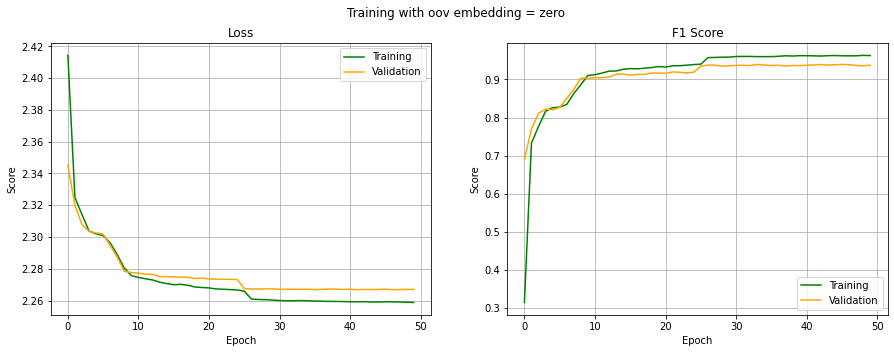

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../logs/zero/fold_{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with oov embedding = zero")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9631, device='cuda:0'),
 tensor(0.9372, device='cuda:0'),
 tensor(0.9355, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9631, device='cuda:0'),
 tensor(0.9372, device='cuda:0'),
 tensor(0.9355, device='cuda:0'))

## Heatmap

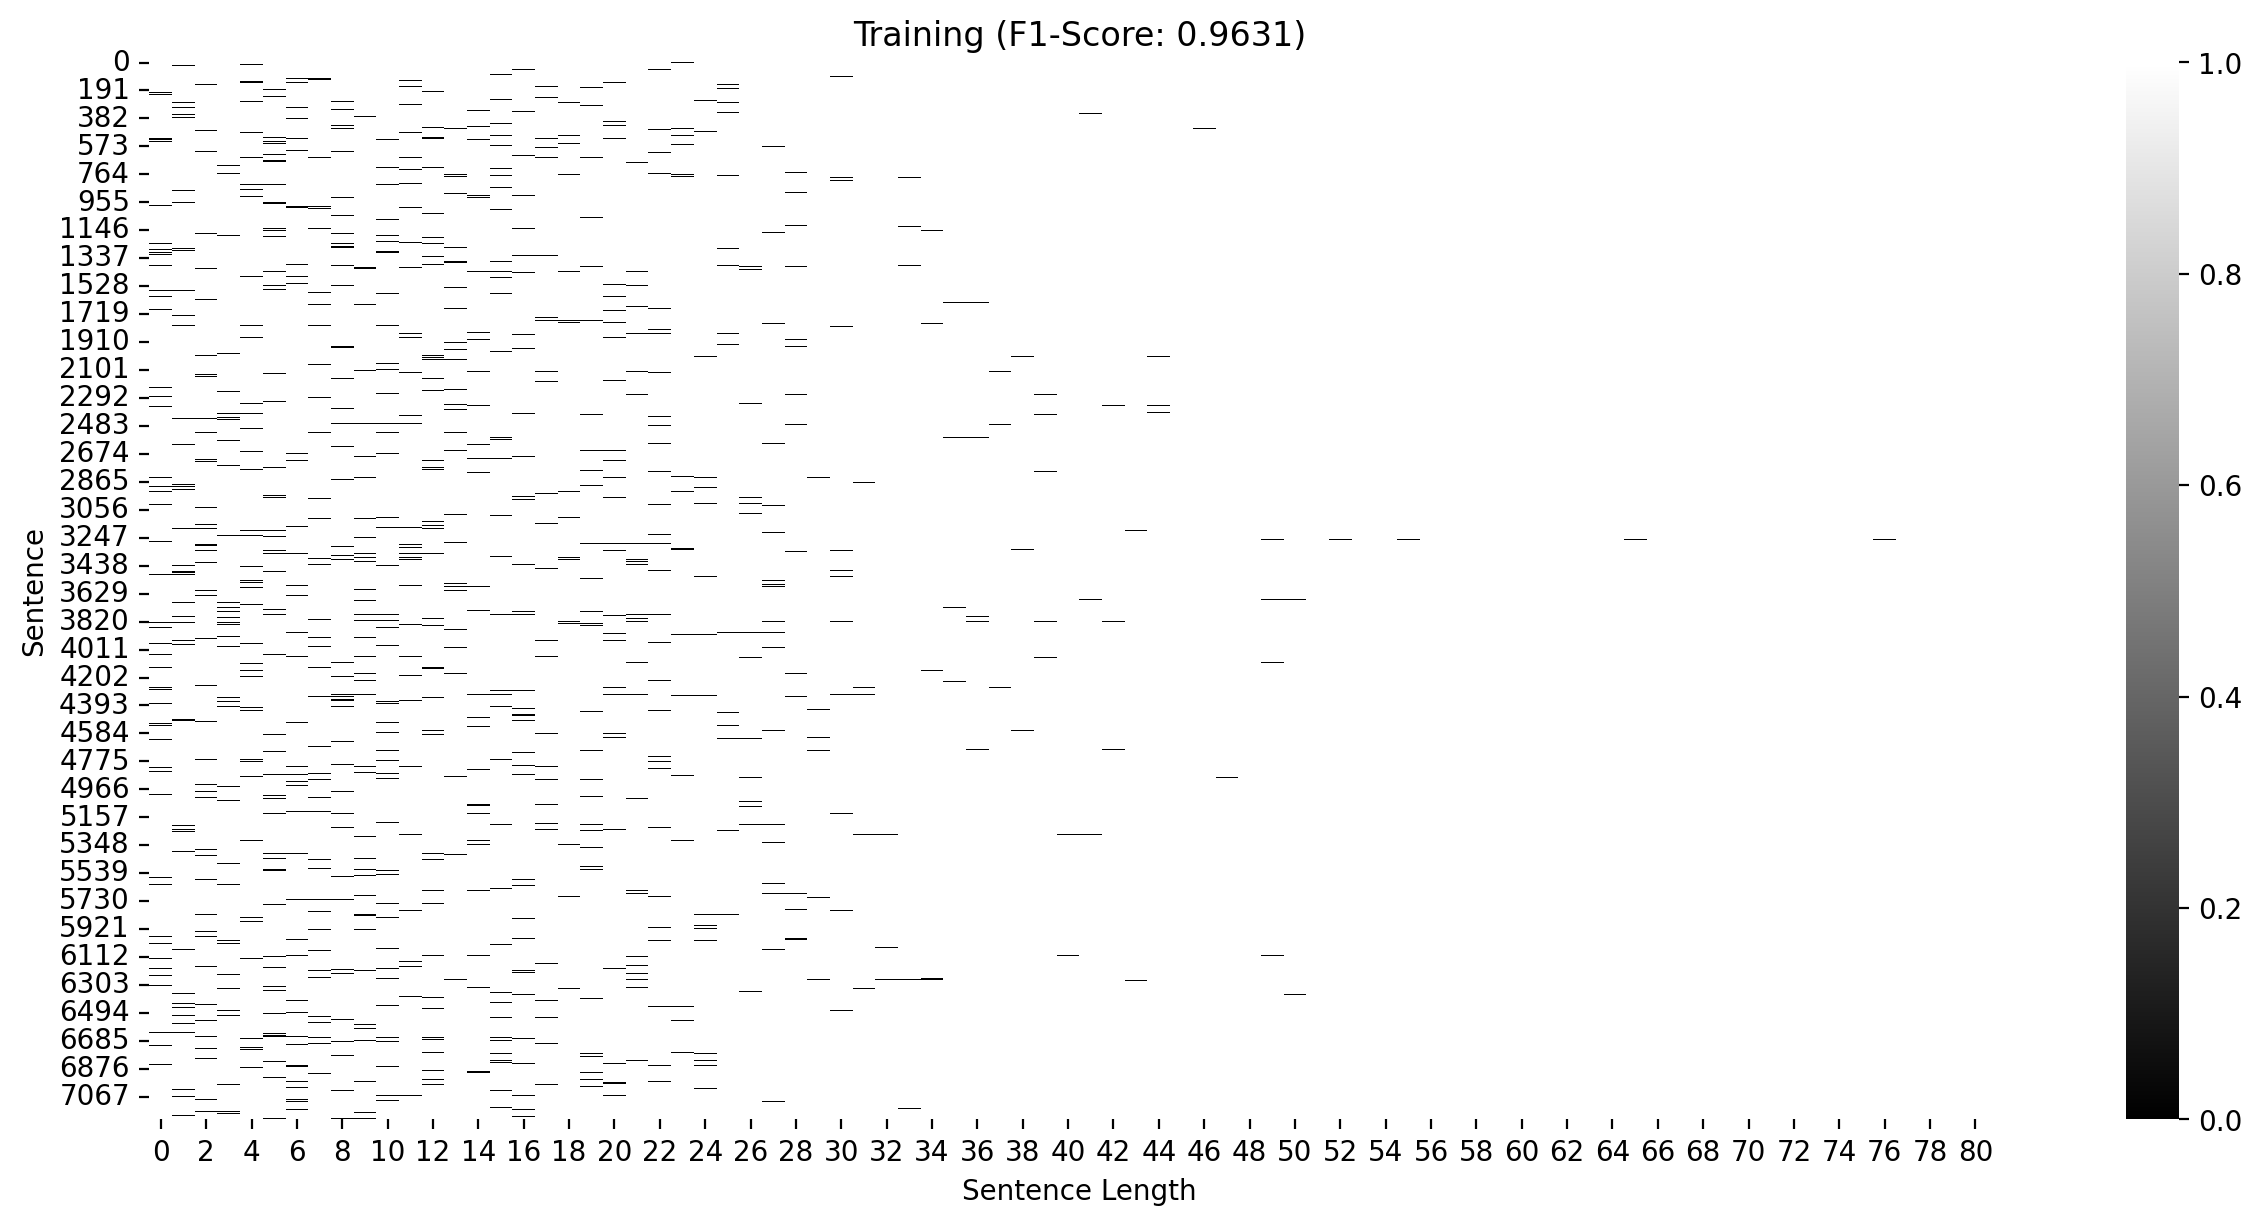

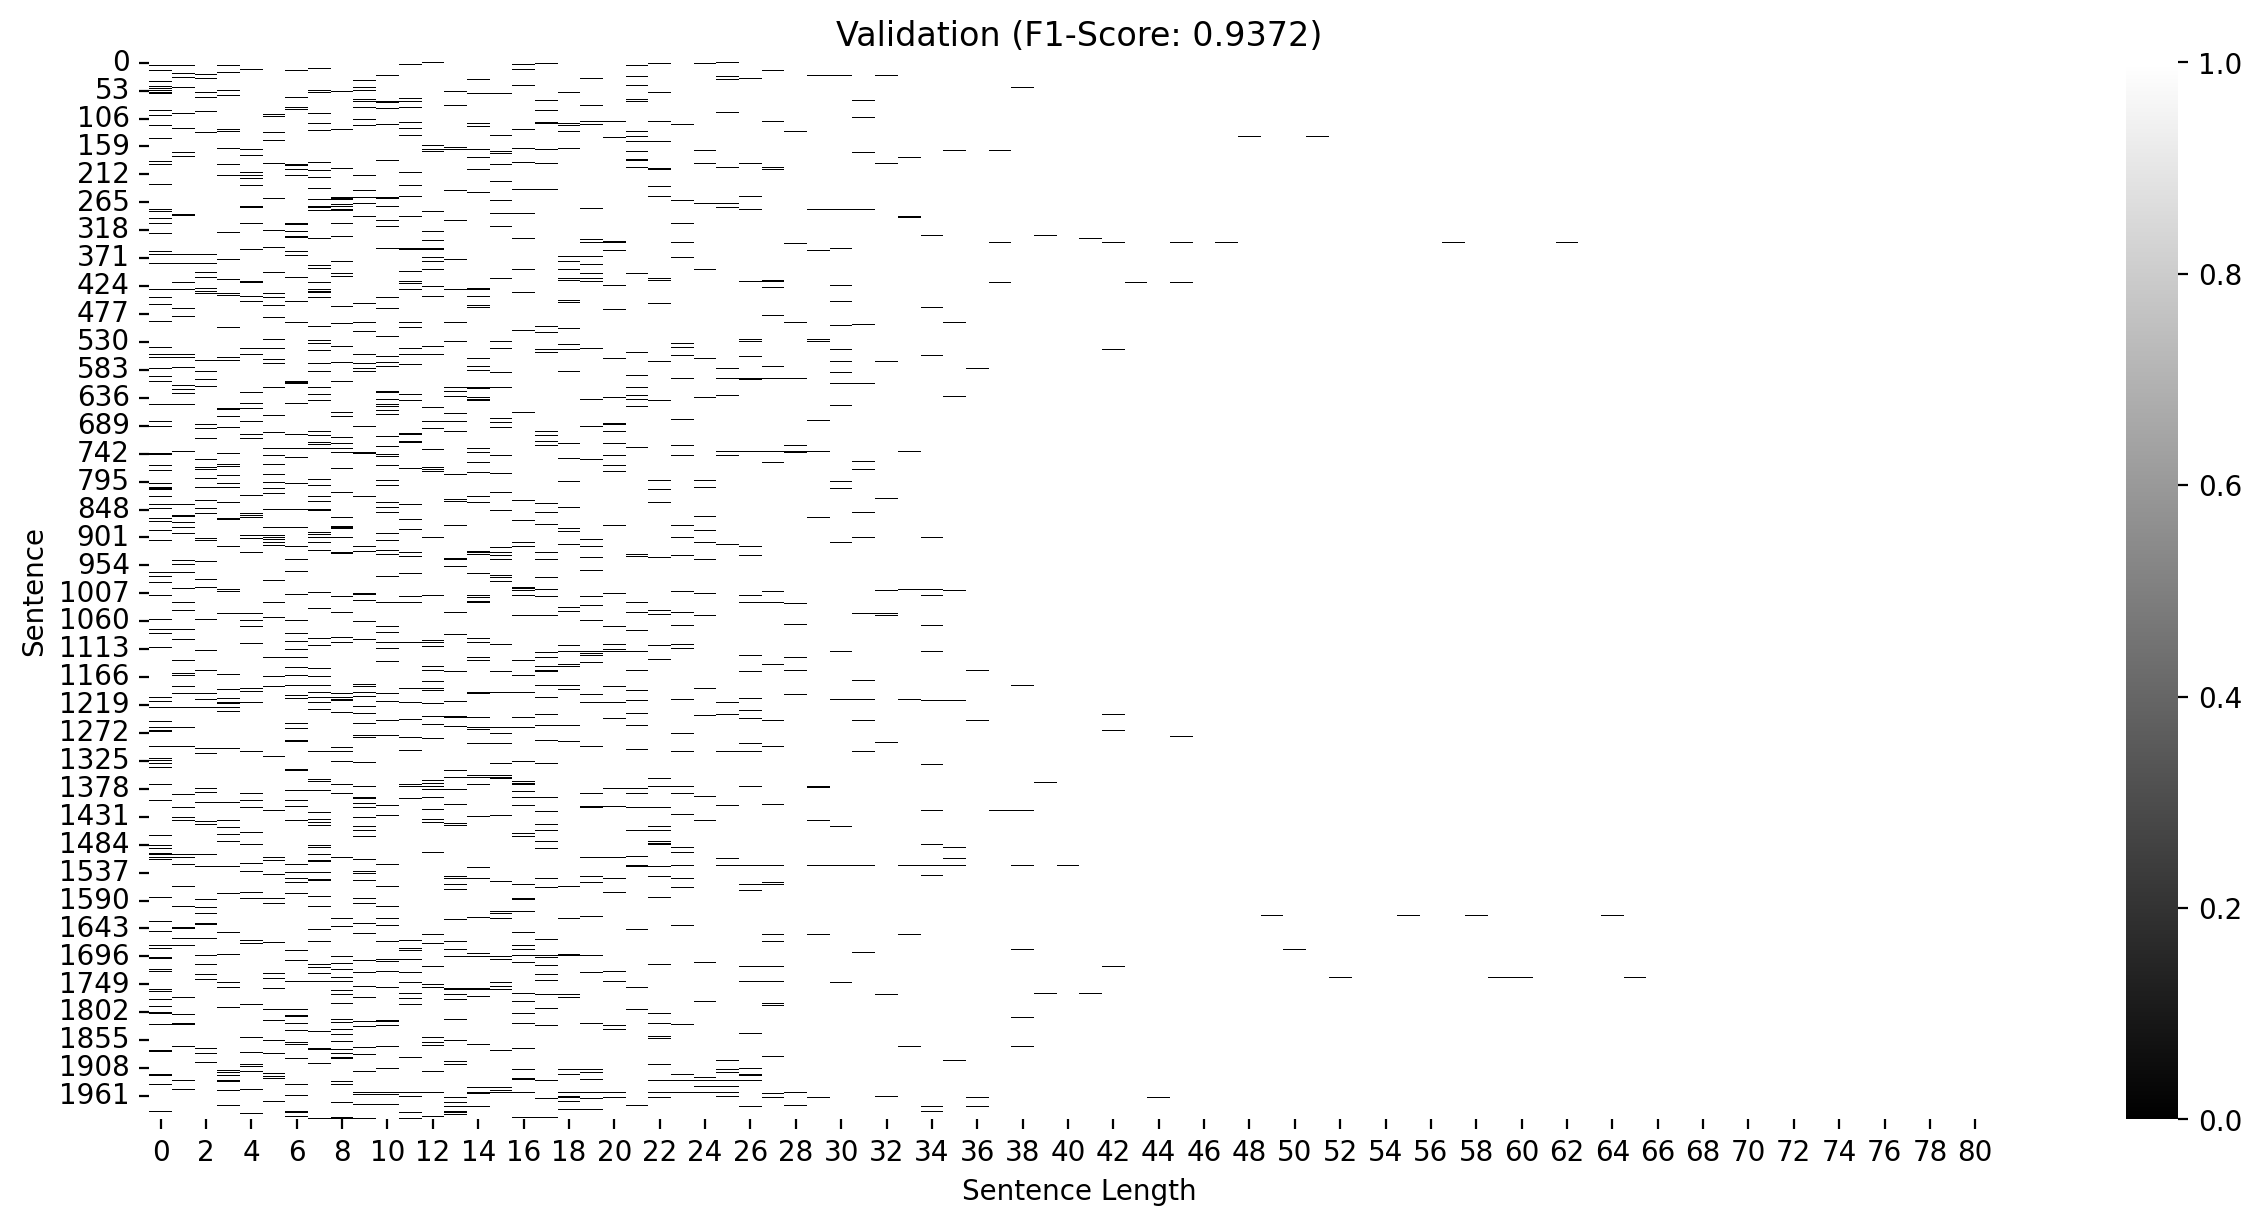

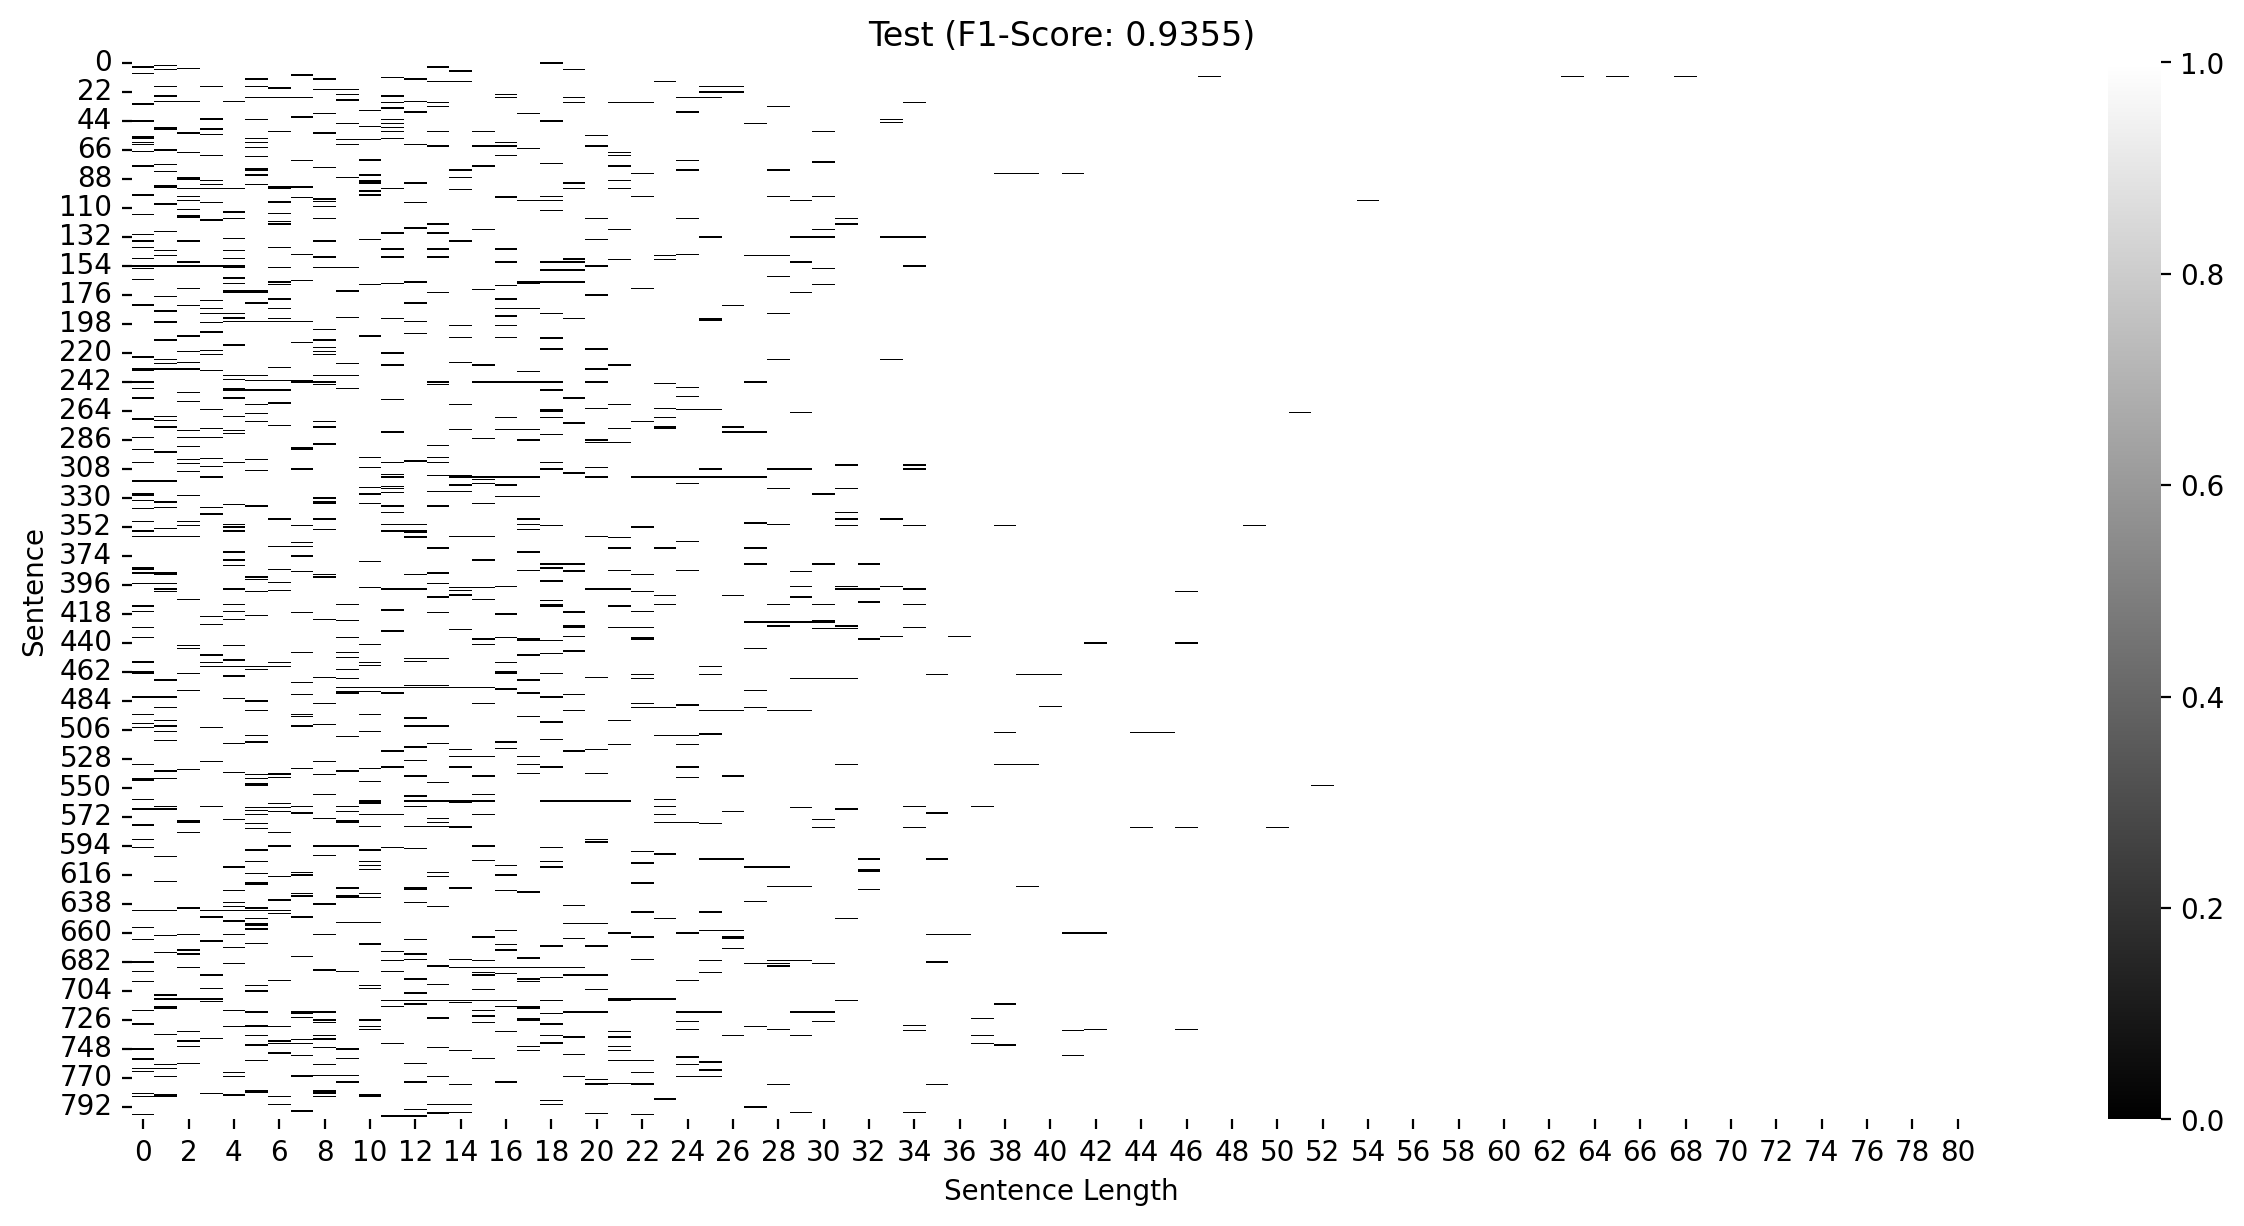

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


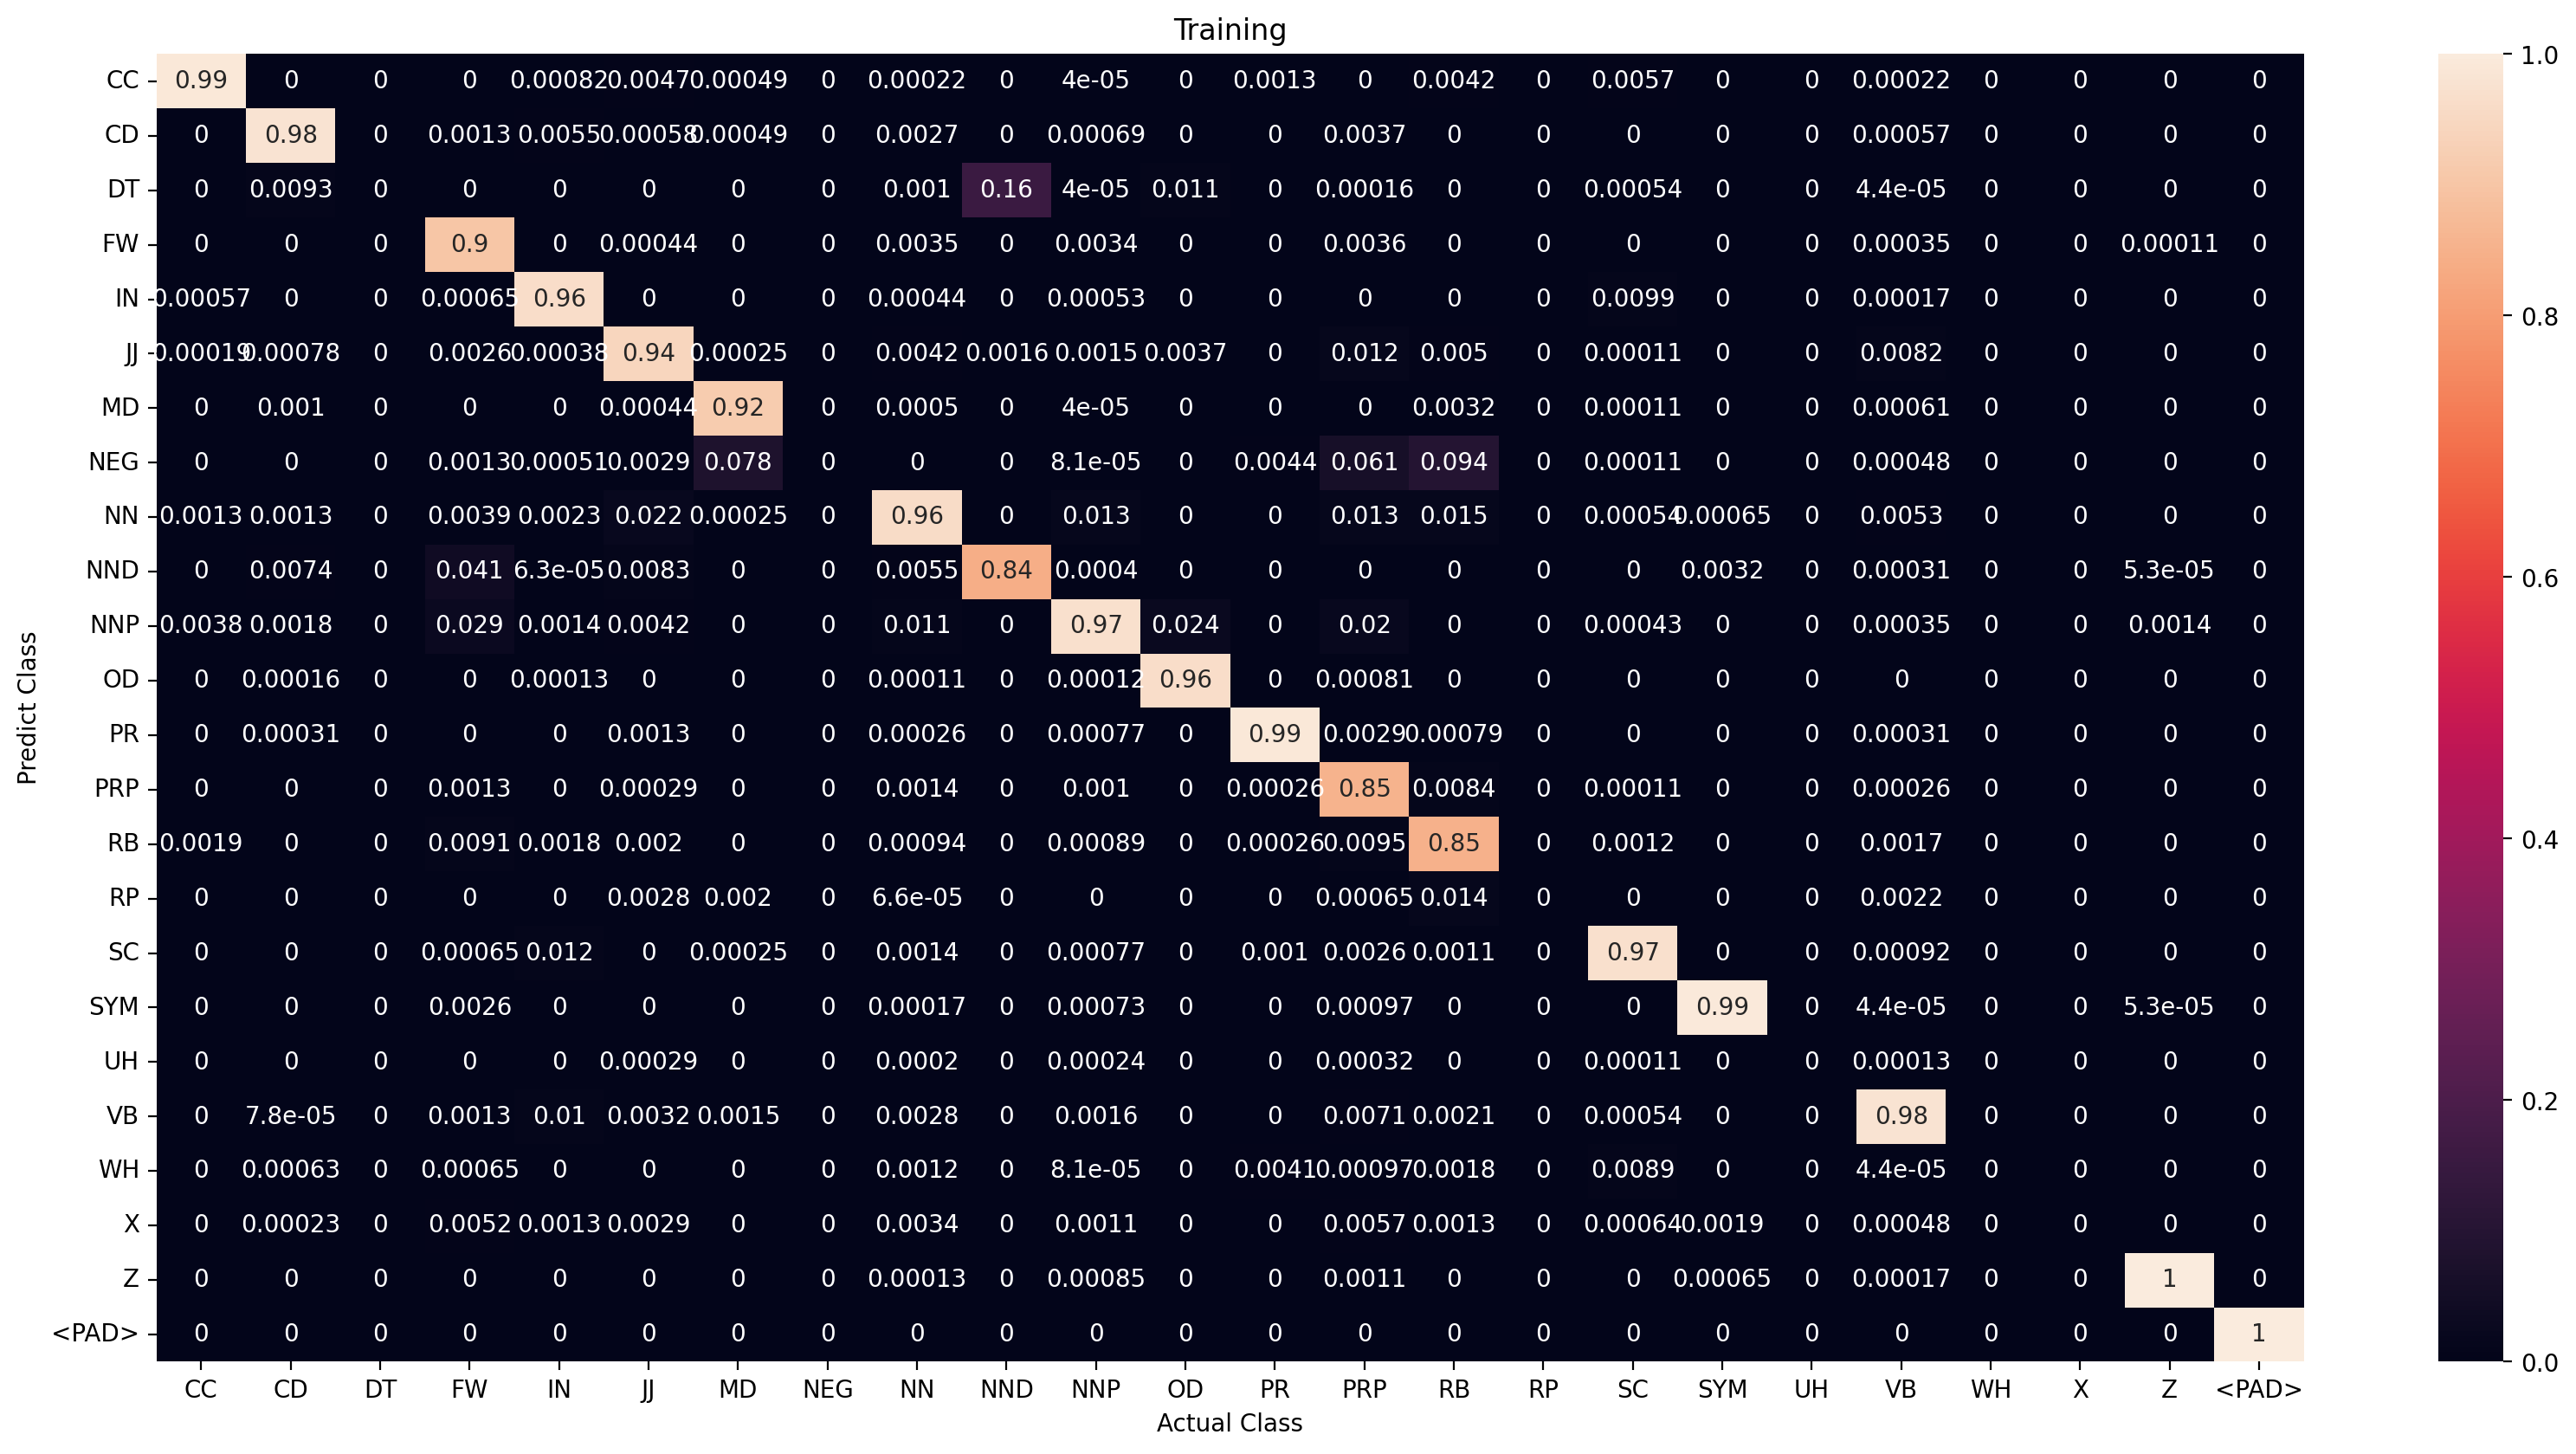

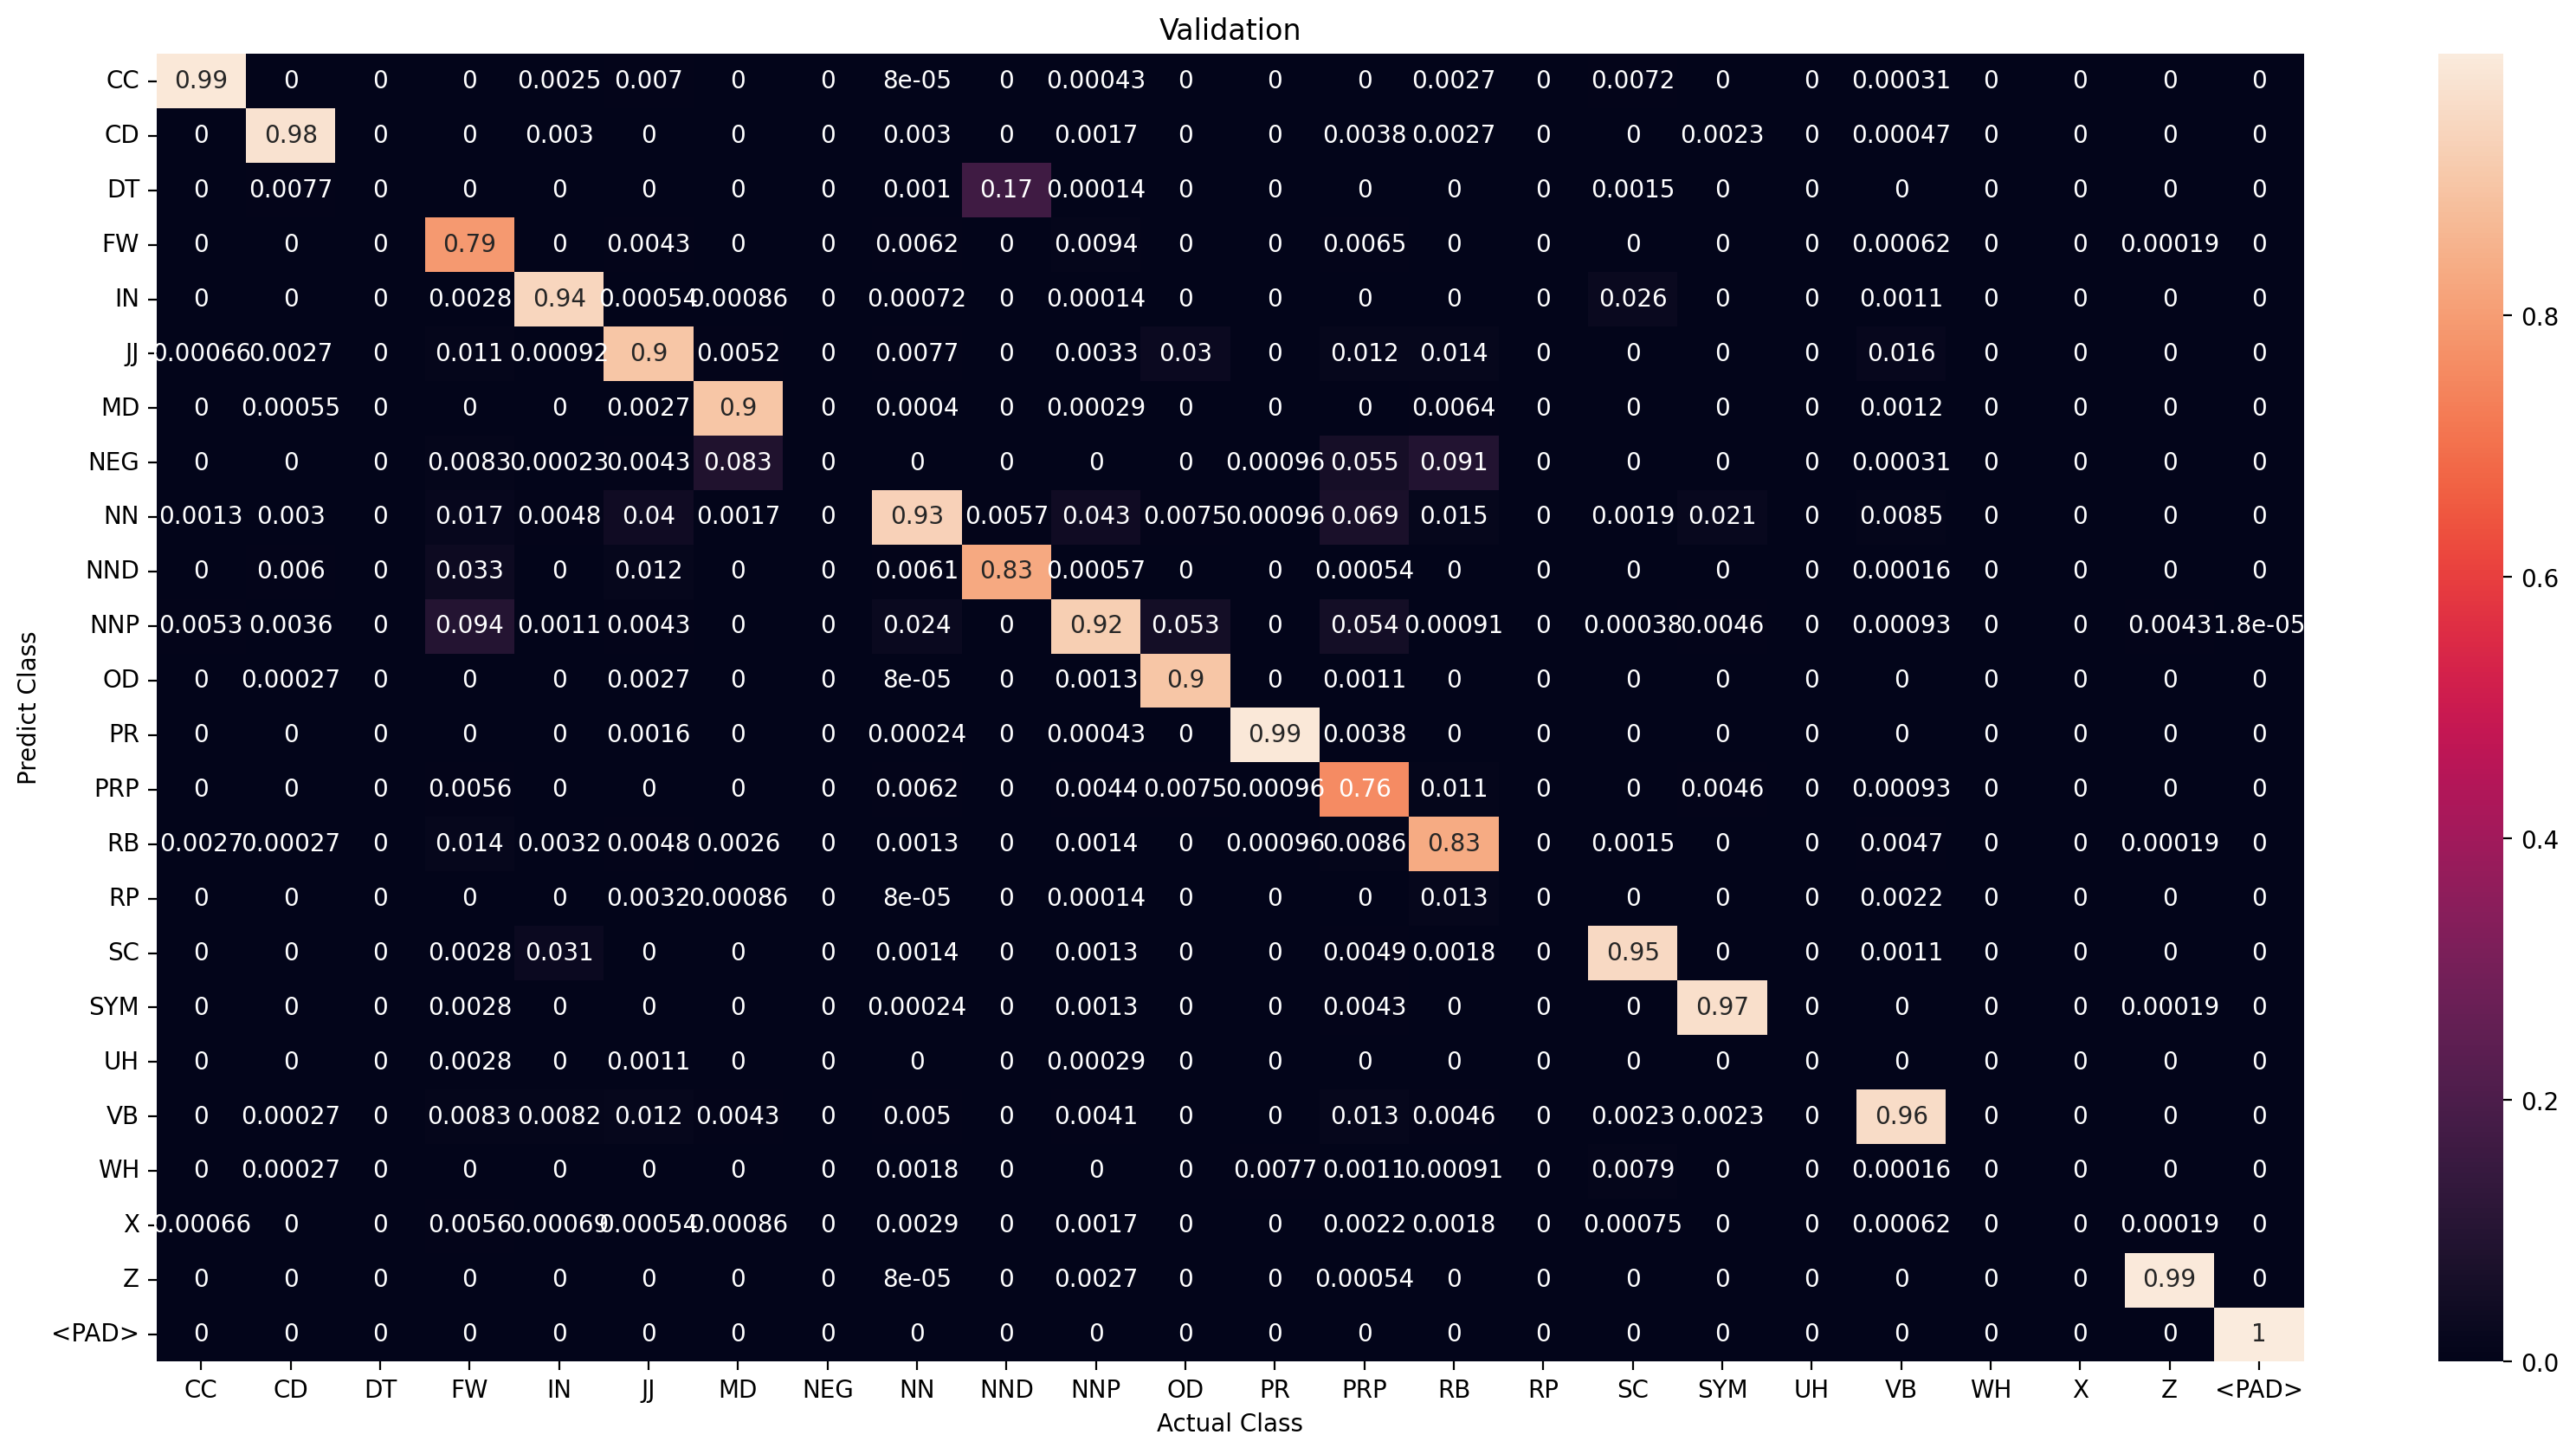

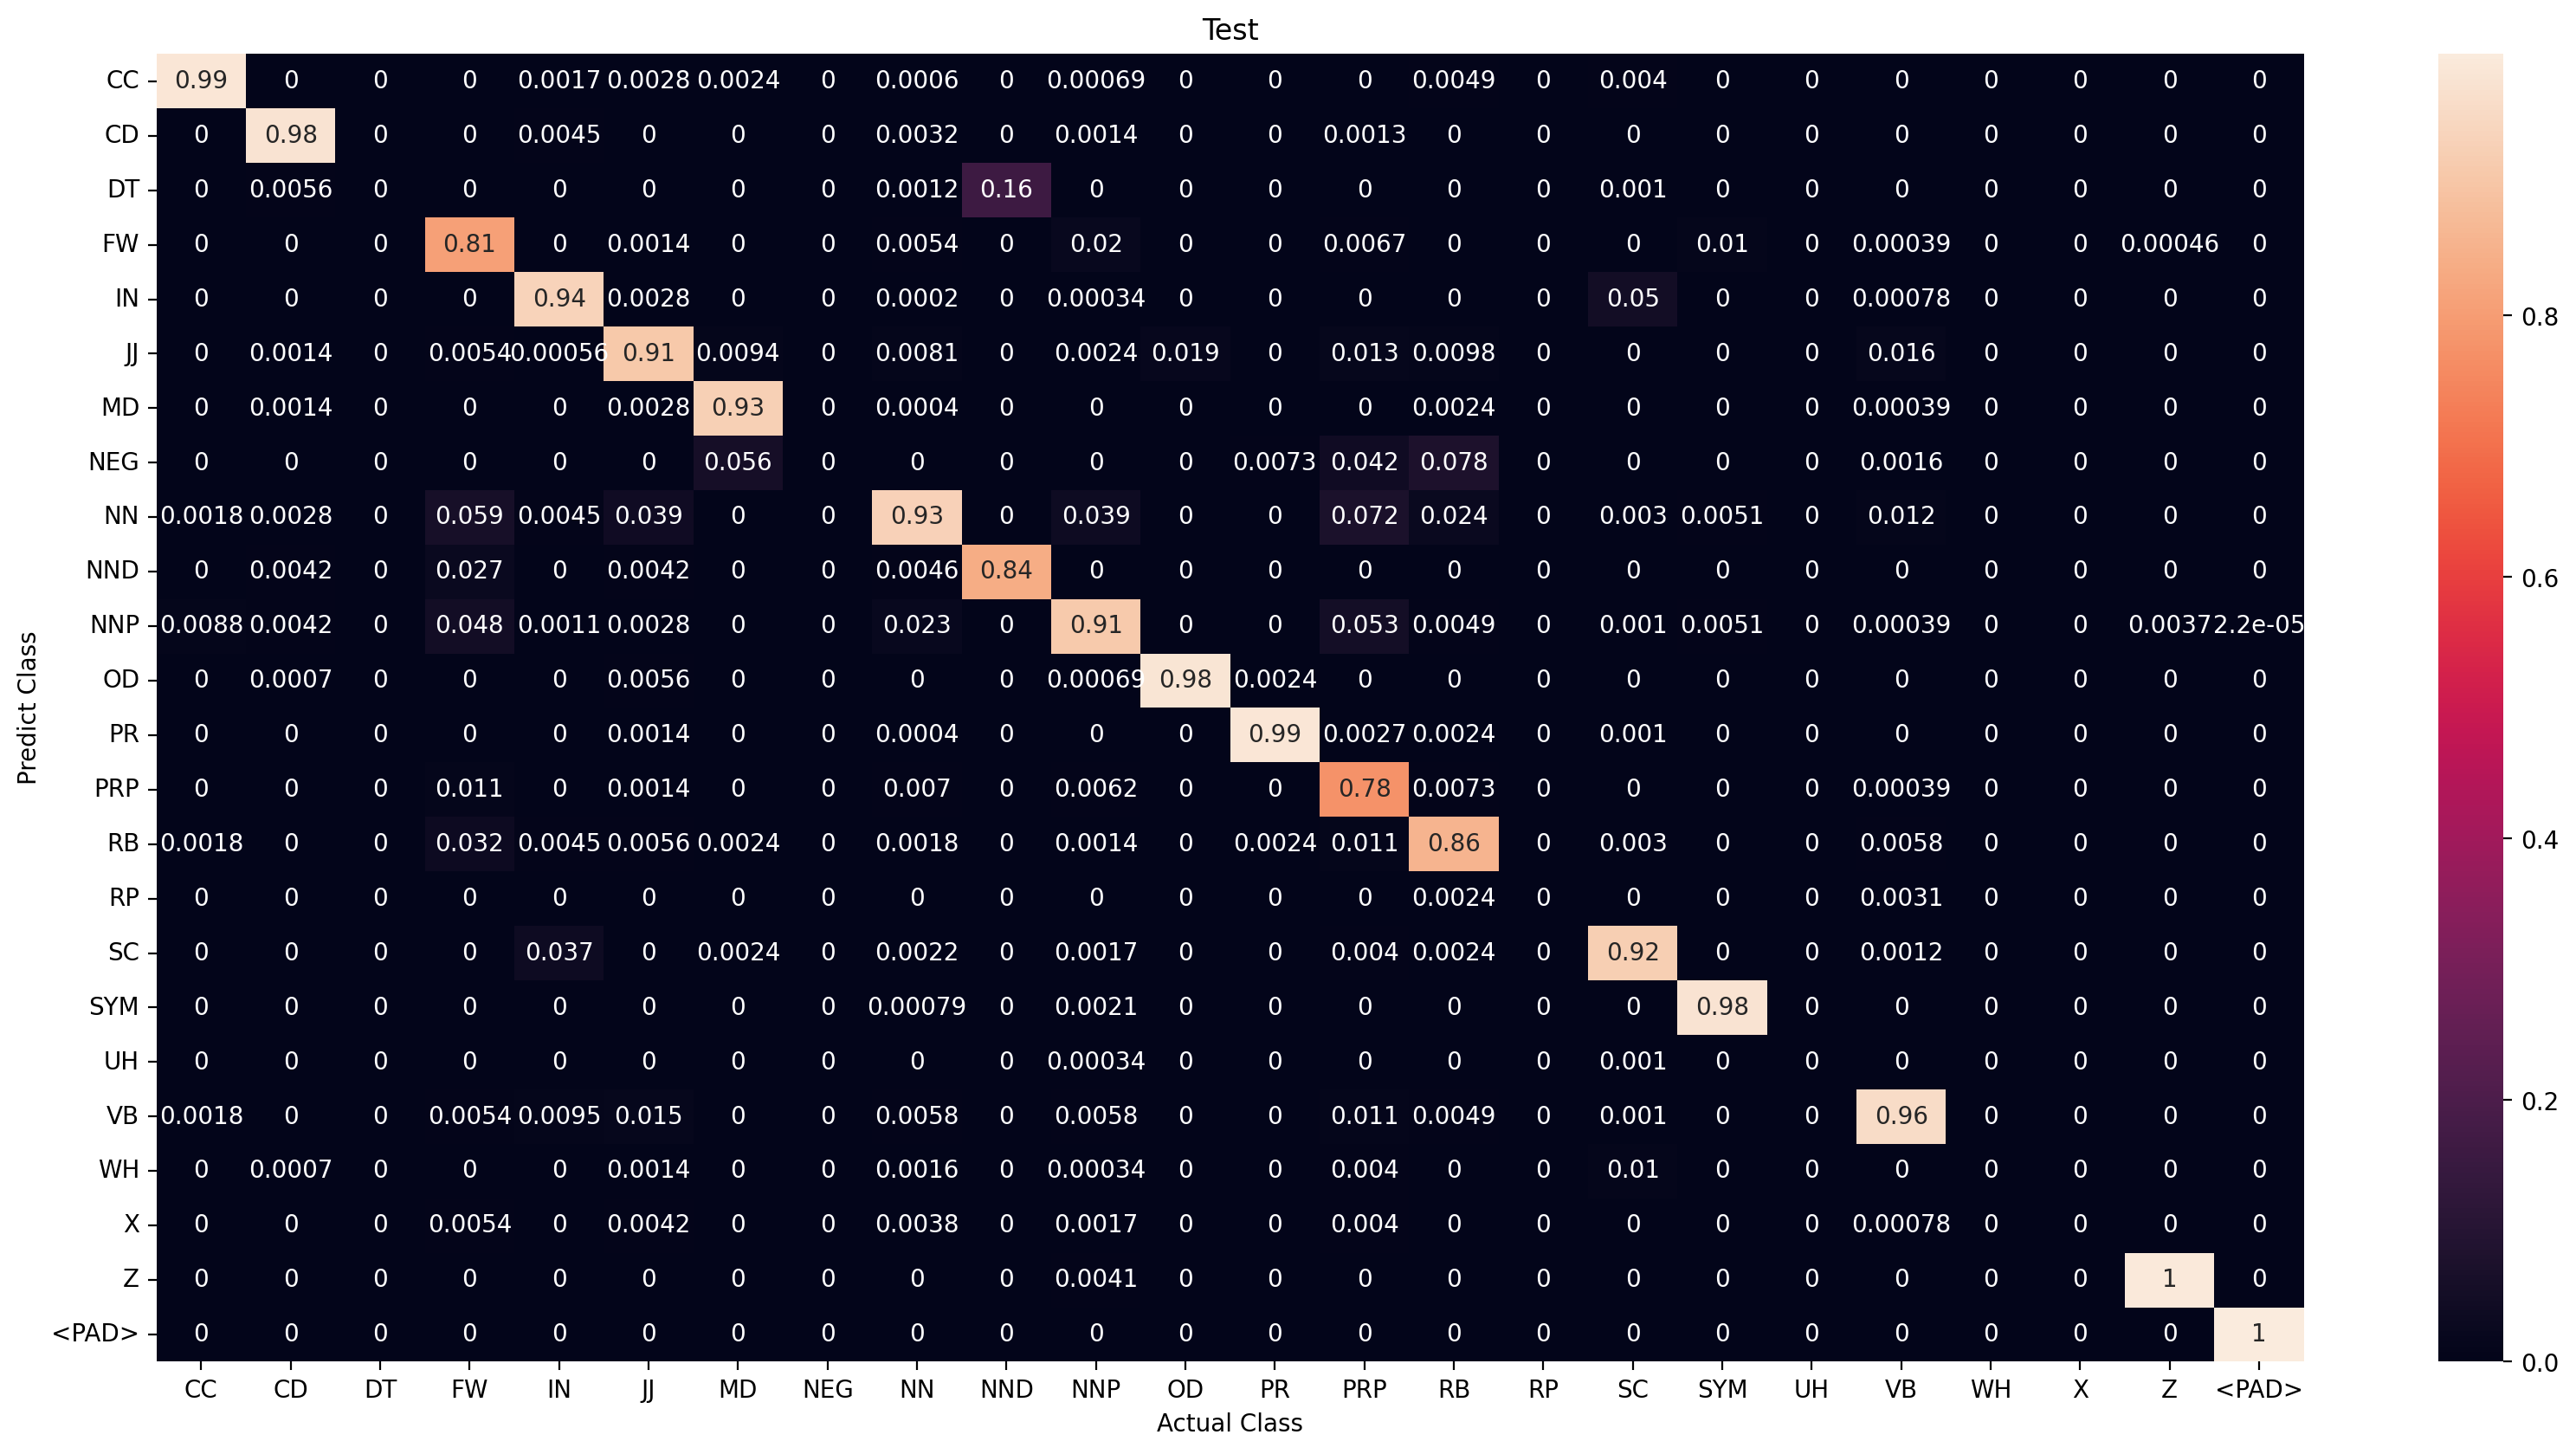

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5322   | CC    : 5185       | CC    : 137      |
| CD    : 12758  | CD    : 12488      | CD    : 270      |
| DT    : 277    | DT    : 0          | DT    : 277      |
| FW    : 1666   | FW    : 1387       | FW    : 279      |
| IN    : 15371  | IN    : 15238      | IN    : 133      |
| JJ    : 6997   | JJ    : 6461       | JJ    : 536      |
| MD    : 3774   | MD    : 3707       | MD    : 67       |
| NEG   : 1113   | NEG   : 0          | NEG   : 1113     |
| NN    : 44672  | NN    : 43873      | NN    : 799      |
| NND   : 1021   | NND   : 530        | NND   : 491      |
| NNP   : 24845  | NNP   : 24044      | NNP   : 801      |
| OD    : 541    | OD    : 524        | OD    : 17       |
| PR    : 3896   | PR    : 3824       | PR    : 72       |
| PRP   : 5408   | PRP   : 5273       | PRP   : 135      |
| RB    : 3463   | RB    : 3220       | RB    : 243      |
| RP    : 137    | RP    : 0          | RP    : 137     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8,  5,  0,  8,
          5, 16, 19, 13,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11821
Correct prediction          : 10291
Wrong prediction            : 1530
Percentage correct oov pred : 87.05693257761611

Validation
Number OOV token            : 3350
Correct prediction          : 2385
Wrong prediction            : 965
Percentage correct oov pred : 71.19402985074626

Test
Number OOV token            : 1391
Correct prediction          : 993
Wrong prediction            : 398
Percentage correct oov pred : 71.38749101365924



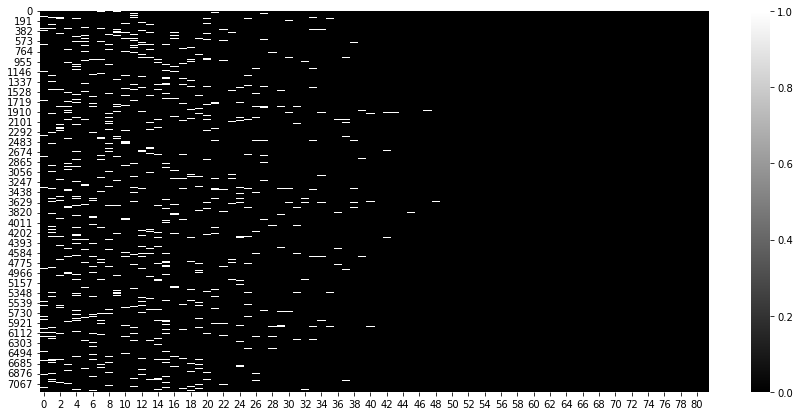

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

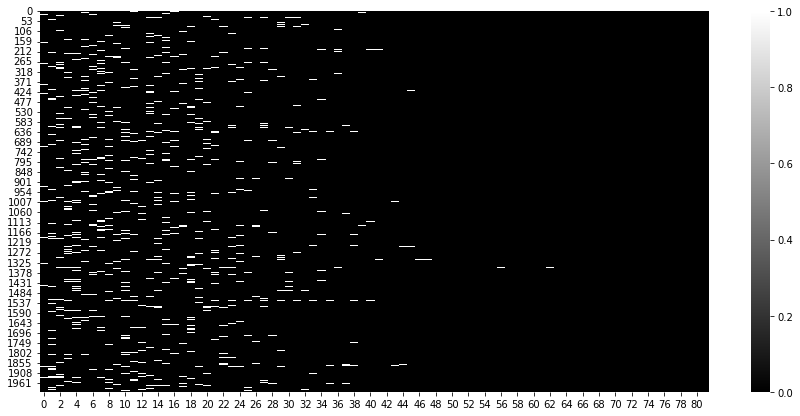

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

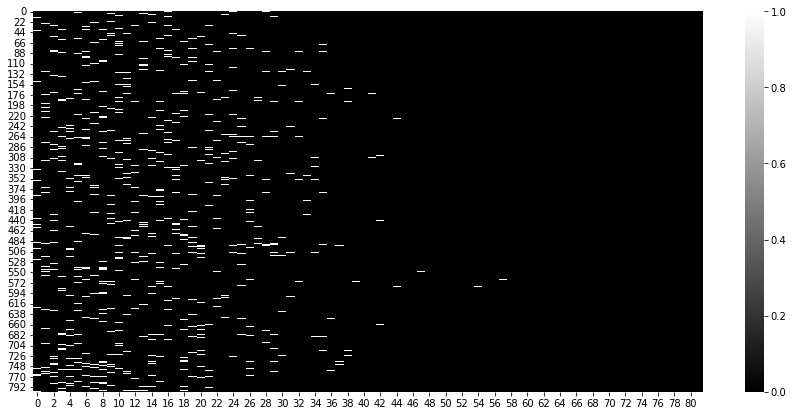

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);